In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

RSEED=42

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Read data</div>

In [2]:
df = pd.read_pickle('data/data_combined_clean_features_7.pkl')

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Train test split</div>

In [3]:
#define train, validation and test dataset
train = df[df['Date'] < "2012-01-06"].reset_index(drop=True)
validation = df[(df['Date'] >= "2012-01-06") & (df['Date'] <= "2012-06-08")].reset_index(drop=True)
test = df[df['Date'] > "2012-06-08"].reset_index(drop=True)

# drop date in each of the datasets
#train = train.drop(columns='Date')
#validation = validation.drop(columns='Date')
#test = test.drop(columns='Date') 
#                
# => In this case, the date col is dropped in the code below, 
# because it is needed for plotting y versus y_predicted 

#define features and target
X_train = train.drop(columns=['Weekly_Sales', 'Date']) # date is dropped here
y_train = train['Weekly_Sales']

X_validation = validation.drop(columns=['Weekly_Sales', 'Date'])
y_validation = validation['Weekly_Sales']

X_test = test.drop(columns=['Weekly_Sales', 'Date'])
y_test = test['Weekly_Sales']  

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Scaling</div>

First define colums to scale, scale using SKlearn's StandardScaler and merge data

In [4]:
'''Before we have a look at the different methods, 
we have to define which columns we want to scale.'''

col_scale = ['Store', 'Dept', 'Fuel_Price', 'CPI',
       'Unemployment', 'Size', 'Year', 'Temp_Celsius', 
       'Month', 'Week', 'Shifted_Rolling_Avg_1',
       'Shifted_Rolling_Avg_2', 'Shifted_Rolling_Avg_3',
       'Shifted_Rolling_Avg_4', 'Shifted_Rolling_Avg_5',
       'Shifted_Rolling_Avg_6', 'Shifted_Rolling_Avg_7',
       'Shifted_Rolling_Avg_8', 'Shifted_Rolling_Avg_9',
       'Shifted_Rolling_Avg_10', 'Shifted_Rolling_Avg_11',
       'Shifted_Rolling_Avg_12', 'Std_Dev', 'EMA']

In [5]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_validation_scaled = scaler.transform(X_validation[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

In [6]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_validation_preprocessed = np.concatenate([X_validation_scaled, X_validation.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">KNN</div>

In [8]:
# instantiate model
model = KNeighborsRegressor()

# fit the model with train data 
model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred_train = model.predict(X_train_preprocessed)
y_pred_validation = model.predict(X_validation_preprocessed)
y_pred_test = model.predict(X_test_preprocessed)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for KNN</div>

In [9]:
def get_metrics(y, y_hat, data_kind):
    '''insert target, predicted target 
    and which kind of dataset as a string'''
    
    mean = y.mean()
    std = y.std()
    mse = mean_squared_error(y, y_hat)
    rmse = np.sqrt(mse)

    print(5*'- - ')
    print(f'Metrics for {data_kind}')
    print('Mean weekly sales:', mean.round(3))
    print('Standard deviation weekly sales:', std.round(3))
    print('MSE:', mse.round(3))
    print('RMSE:', rmse.round(3))
    print(5*'- - ')


In [10]:
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.936
Standard deviation weekly sales: 23533.857
MSE: 11934986.371
RMSE: 3454.705
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 13452006.987
RMSE: 3667.698
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 9883944.211
RMSE: 3143.874
- - - - - - - - - - 


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">GridSearchCV</div>

In [11]:
# instantiate model
model = KNeighborsRegressor()

In [12]:
# Defining parameter grid (as dictionary)
param_grid = {
            "n_neighbors" : [10, 20],
            "leaf_size" : [30, 40],
            "p" :[1, 2],
             }

'''When p = 1, this is equivalent to using manhattan_distance (l1), 
and euclidean_distance (l2) for p = 2. 
For arbitrary p, minkowski_distance (l_p) is used.'''

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsRegressor(),
                     param_grid, 
                     scoring= "neg_root_mean_squared_error",
                     cv=2,
                     verbose=5,
                     n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
#start = timer()
gs.fit(X_train, y_train)
#end = timer()
#gs_time = end-start

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[CV 1/2] END leaf_size=30, n_neighbors=10, p=2;, score=-6651.214 total time= 2.0min
[CV 2/2] END leaf_size=30, n_neighbors=10, p=2;, score=-4735.599 total time= 2.0min
[CV 1/2] END leaf_size=30, n_neighbors=20, p=2;, score=-6993.333 total time= 2.1min
[CV 2/2] END leaf_size=30, n_neighbors=20, p=2;, score=-5004.136 total time= 2.1min
[CV 1/2] END leaf_size=40, n_neighbors=10, p=2;, score=-6651.214 total time= 2.1min
[CV 2/2] END leaf_size=40, n_neighbors=10, p=2;, score=-4735.599 total time= 2.1min
[CV 1/2] END leaf_size=30, n_neighbors=20, p=1;, score=-7457.177 total time= 9.6min
[CV 2/2] END leaf_size=30, n_neighbors=10, p=1;, score=-4917.185 total time= 9.6min
[CV 1/2] END leaf_size=30, n_neighbors=10, p=1;, score=-7016.104 total time= 9.6min
[CV 2/2] END leaf_size=30, n_neighbors=20, p=1;, score=-5412.473 total time= 9.7min
[CV 1/2] END leaf_size=40, n_neighbors=10, p=1;, score=-7016.104 total time= 9.4min
[CV 1/2] END leaf_size=40, n_neighbors=20, p=2;, score=-6993.333 total time=

GridSearchCV(cv=2, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [30, 40], 'n_neighbors': [10, 20],
                         'p': [1, 2]},
             scoring='neg_root_mean_squared_error', verbose=5)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Best parameters I</div>

In [13]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: -5693.407
Best parameters: {'leaf_size': 30, 'n_neighbors': 10, 'p': 2}


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">KNN with tuned hyperparameter grid I</div>

In [16]:
# instantiate model
model = KNeighborsRegressor(leaf_size =30, n_neighbors=10, p=2)

# fit the model with train data 
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)
y_pred_test = model.predict(X_test)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for KNN with tuned parameter grid I</div>

In [17]:
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.936
Standard deviation weekly sales: 23533.857
MSE: 14220475.597
RMSE: 3771.005
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 11794319.181
RMSE: 3434.286
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 6209345.164
RMSE: 2491.856
- - - - - - - - - - 


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">GridSearchCV II</div>

In [ ]:
# Defining parameter grid (as dictionary)
param_grid = {
            "n_neighbors" : [7, 10, 15],
            "leaf_size" : [20, 30],
            "p" :[1.5, 2],
             }

'''When p = 1, this is equivalent to using manhattan_distance (l1), 
and euclidean_distance (l2) for p = 2. 
For arbitrary p, minkowski_distance (l_p) is used.'''

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsRegressor(),
                     param_grid, 
                     scoring= "neg_root_mean_squared_error",
                     cv=2,
                     verbose=5,
                     n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
#start = timer()
gs.fit(X_train, y_train)
#end = timer()
#gs_time = end-start

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Best parameters II</div>

In [ ]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">KNN with tuned hyperparameter grid II</div>

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for KNN with tuned parameter grid II</div>

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Adding predicted values to train, validation and test dataframe</div>

In [18]:
train['Predicted_Sales'] = y_pred_train
validation['Predicted_Sales'] = y_pred_validation
test['Predicted_Sales'] = y_pred_test

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Plotting actual target versus predicted target </div>

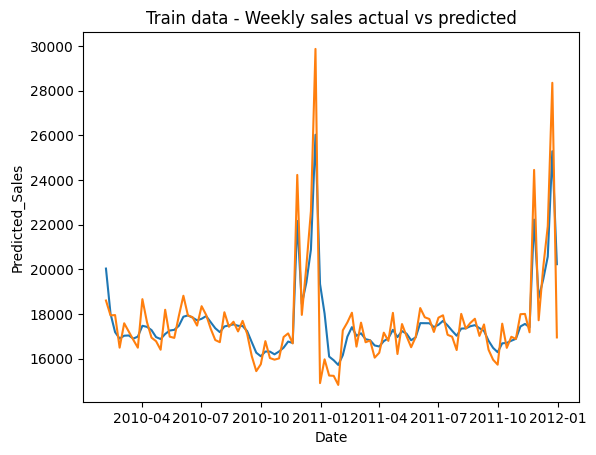

In [19]:
sns.lineplot(data=train, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=train, x='Date', y='Weekly_Sales', errorbar=None)
plt.title('Train data - Weekly sales actual vs predicted');

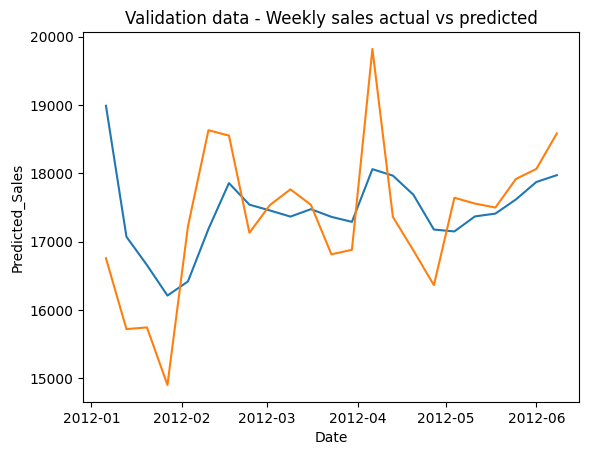

In [20]:
sns.lineplot(data=validation, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=validation, x='Date', y='Weekly_Sales', errorbar=None)
plt.title('Validation data - Weekly sales actual vs predicted');

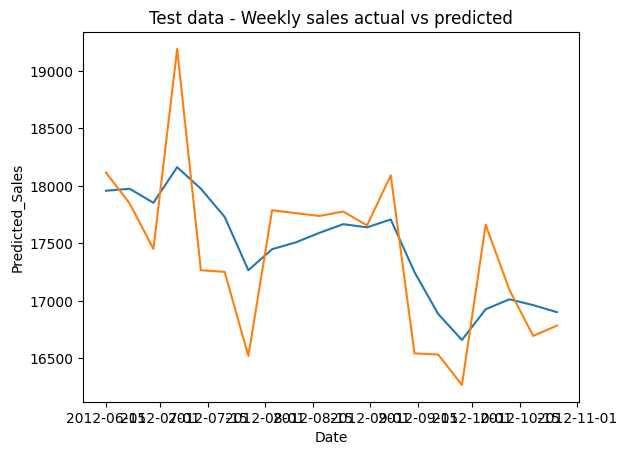

In [21]:
sns.lineplot(data=test, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=test, x='Date', y='Weekly_Sales', errorbar=None)
plt.title('Test data - Weekly sales actual vs predicted');

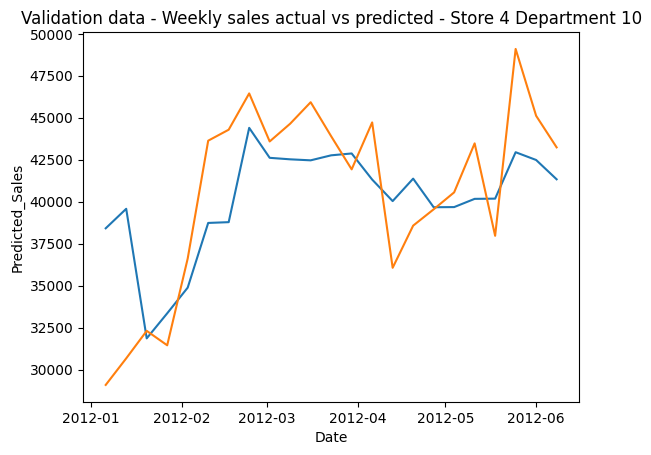

In [22]:
sns.lineplot(data=validation.query('Store==4 and Dept==10'), x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=validation.query('Store==4 and Dept==10'), x='Date', y='Weekly_Sales', errorbar=None)
plt.title('Validation data - Weekly sales actual vs predicted - Store 4 Department 10');

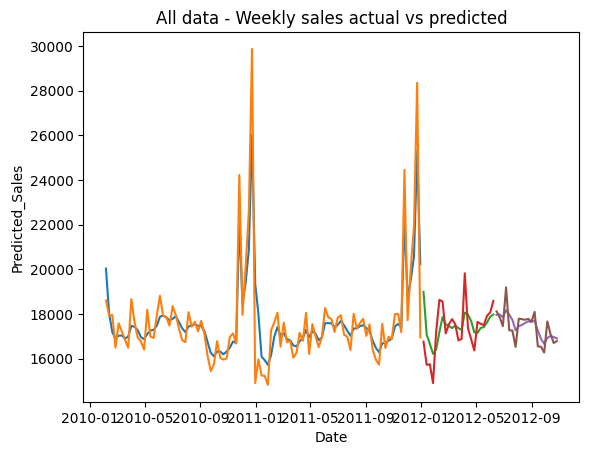

In [23]:
sns.lineplot(data=train, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=train, x='Date', y='Weekly_Sales', errorbar=None)
sns.lineplot(data=validation, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=validation, x='Date', y='Weekly_Sales', errorbar=None)
sns.lineplot(data=test, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=test, x='Date', y='Weekly_Sales', errorbar=None)
plt.title('All data - Weekly sales actual vs predicted');

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis</div>

In [24]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Train</div>

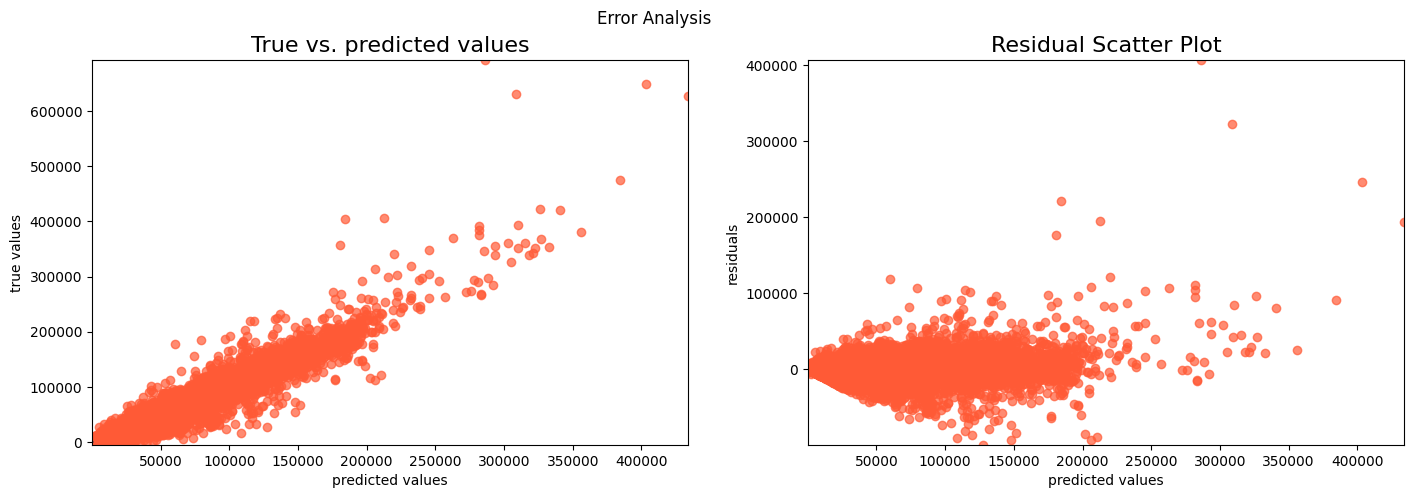

In [25]:
error_analysis(y_train, y_pred_train)

In [26]:
#train['Residuals'] = train.Weekly_Sales - train.Predicted_Sales
#train.query('Residuals >= 25000 or Residuals <= -25000')

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Validation</div>

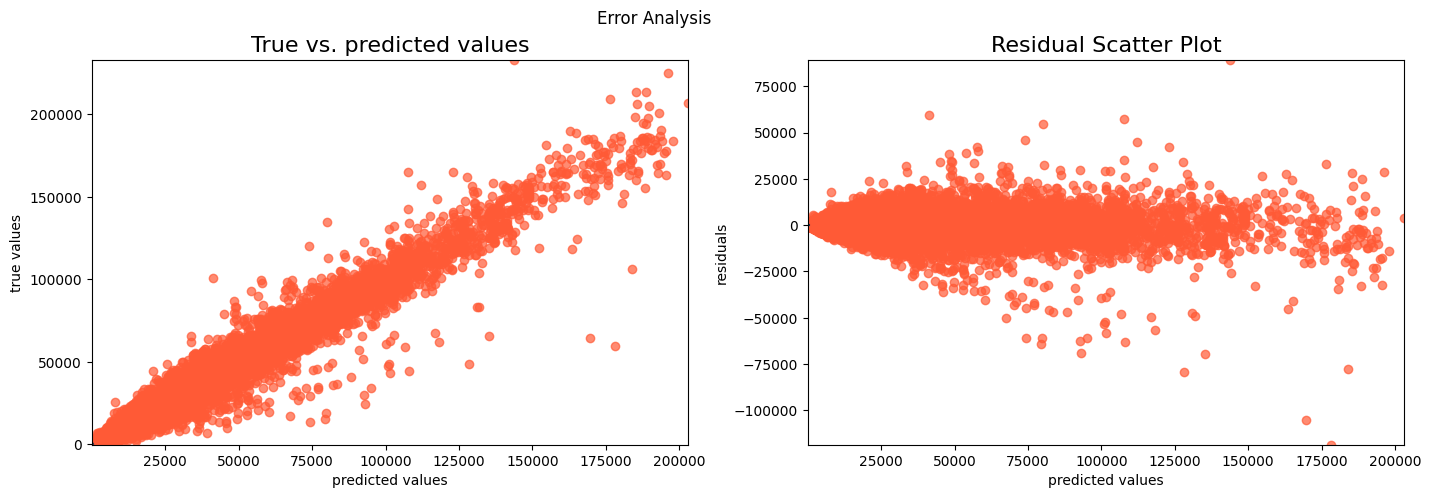

In [27]:
error_analysis(y_validation, y_pred_validation)

In [29]:
validation['Residuals'] = validation.Weekly_Sales - validation.Predicted_Sales
validation.query('Residuals >= 25000 or Residuals <= -25000')

,Store,Dept,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Size,Year,Temp_Celsius,...,Shifted_Rolling_Avg_10,Shifted_Rolling_Avg_11,Shifted_Rolling_Avg_12,Std_Dev,EMA,IsHoliday_True,Type_B,Type_C,Predicted_Sales,Residuals
1155,1,72,2012-02-10,98104.80,3.409,220.265178,7.348,151315,2012,8.90,...,63564.377143,57374.7385,52785.116786,22089.360702,63354.284232,1,0,0,58031.300,40073.500
1416,1,92,2012-04-06,165039.54,3.891,221.435611,7.143,151315,2012,21.35,...,146572.303571,152106.4815,147930.282143,14900.824318,145292.550395,0,0,0,123027.524,42012.016
1679,2,7,2012-01-06,19058.99,3.157,219.355063,7.057,202307,2012,8.19,...,71910.960714,57592.7105,50041.731786,63350.179278,83374.571079,0,0,0,49685.200,-30626.210
2668,2,72,2012-01-06,58836.73,3.157,219.355063,7.057,202307,2012,8.19,...,96452.590714,84633.7895,76880.060357,74502.446195,101523.544327,0,0,0,106603.490,-47766.760
2783,2,82,2012-01-06,22640.50,3.157,219.355063,7.057,202307,2012,8.19,...,32735.067857,29239.0405,27180.992143,28847.542470,42997.213875,0,0,0,47714.226,-25073.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55420,40,92,2012-04-06,130621.73,3.957,137.797097,4.125,155083,2012,2.52,...,100525.792143,103841.9380,102595.031071,16640.218286,102289.097490,0,0,0,101194.111,29427.619
56673,41,72,2012-01-13,45825.98,3.077,196.733052,6.589,196321,2012,-2.51,...,81249.240714,73506.4510,65808.309643,33201.133565,80106.111135,0,0,0,76544.582,-30718.602
58015,43,1,2012-03-09,6855.45,3.669,212.518594,9.653,41062,2012,12.51,...,8013.221429,8376.7985,7467.276786,23959.627654,18283.179368,0,0,1,39224.623,-32369.173
58016,43,1,2012-03-16,7932.81,3.734,212.665157,9.653,41062,2012,14.38,...,12677.340000,11564.2605,9839.889643,23795.805205,16213.105495,0,0,1,35640.661,-27707.851


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Test</div>

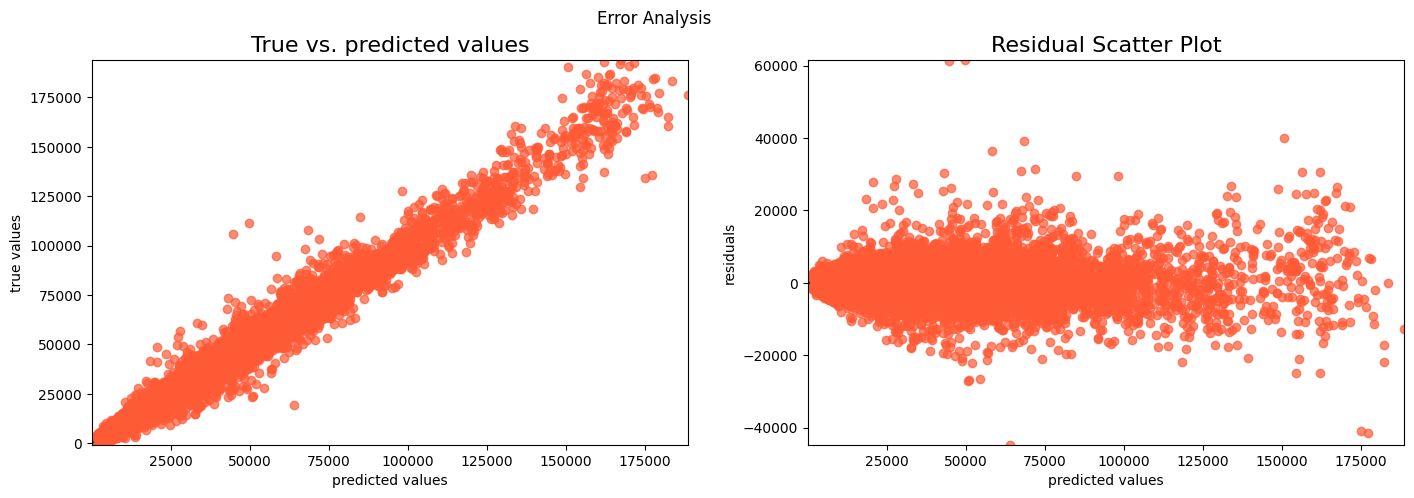

In [30]:
error_analysis(y_test, y_pred_test)

In [31]:
test['Residuals'] = test.Weekly_Sales - test.Predicted_Sales
test.query('Residuals >= 10000 or Residuals <= -10000')

,Store,Dept,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Size,Year,Temp_Celsius,...,Shifted_Rolling_Avg_10,Shifted_Rolling_Avg_11,Shifted_Rolling_Avg_12,Std_Dev,EMA,IsHoliday_True,Type_B,Type_C,Predicted_Sales,Residuals
51,1,3,2012-08-31,50701.30,3.638,222.305480,6.908,151315,2012,26.94,...,15041.377857,13306.1655,12444.662143,11021.682446,31077.197077,0,0,0,40043.023,10658.277
52,1,3,2012-09-07,18368.51,3.730,222.439015,6.908,151315,2012,28.87,...,17548.732143,15025.0425,13563.373929,11366.300858,28535.459662,1,0,0,33331.521,-14963.011
53,1,3,2012-09-14,14288.22,3.717,222.582019,6.908,151315,2012,23.87,...,20574.158571,17163.7210,15008.499643,12892.751340,25686.011729,0,0,0,27775.953,-13487.733
171,1,9,2012-08-31,41634.69,3.638,222.305480,6.908,151315,2012,26.94,...,26564.640714,28217.2420,29136.307500,7164.497507,28195.415775,0,0,0,30398.728,11235.962
202,1,11,2012-06-29,44553.45,3.286,221.843400,7.143,151315,2012,29.38,...,26758.779286,25873.0625,26013.575000,7254.755573,31414.785812,0,0,0,30117.868,14435.582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52033,45,3,2012-09-14,15488.13,3.948,191.699850,8.684,118221,2012,19.93,...,12998.863571,10953.0285,9978.335357,9153.958141,21164.038501,0,1,0,26241.323,-10753.193
52114,45,7,2012-09-21,24406.19,4.038,191.856704,8.684,118221,2012,18.51,...,20039.370714,19886.4515,19172.532143,4230.594785,17175.681856,0,1,0,13680.057,10726.133
52181,45,11,2012-06-22,31596.72,3.564,191.064610,8.567,118221,2012,23.46,...,14509.707857,13521.1265,13966.312857,10943.476723,20190.482790,0,1,0,17005.180,14591.540
52185,45,11,2012-07-20,15193.89,3.567,191.167043,8.684,118221,2012,26.05,...,19035.213571,16815.5380,15443.125357,9688.298091,22312.383431,0,1,0,28083.622,-12889.732


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Merge validation and test</div>

In [32]:
validation_and_test = pd.concat([validation, test], axis=0)

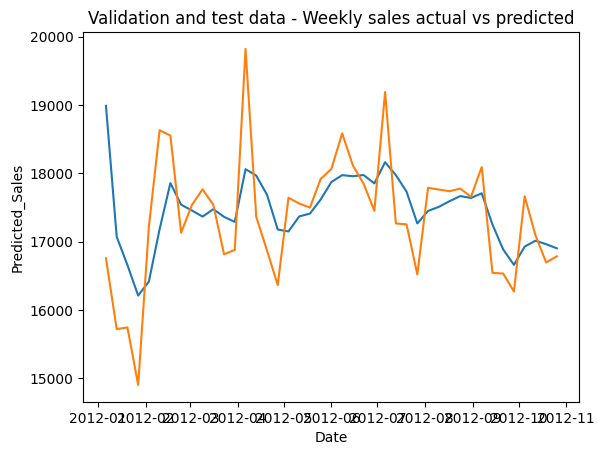

In [33]:
sns.lineplot(data=validation_and_test, x='Date', y='Predicted_Sales', errorbar=None)
sns.lineplot(data=validation_and_test, x='Date', y='Weekly_Sales', errorbar=None)
plt.title('Validation and test data - Weekly sales actual vs predicted');